<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment10/Assignment_10_IDL_Adversarial_Meghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Team Assignment

1. Srinath Mannam (229750)
2. Meghana Rao (234907)
3. Govind Shukla (235192)



##Import Statements


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Load Dataset

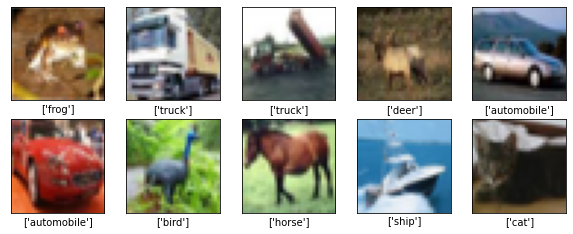

In [43]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = tf.data.Dataset.from_tensor_slices((train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.astype(np.int32).reshape(-1)))
train_data = train_data.shuffle(buffer_size=60000).batch(100).repeat(10)
test_data = tf.data.Dataset.from_tensor_slices((test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.astype(np.int32).reshape(-1))).batch(100)

cifar_10_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(np.array(cifar_10_class_labels)[train_labels[i].astype(int)])
plt.show()


##Model

In [44]:
input_shape = (32, 32, 3)
num_classes = 10
layer_list = [tf.keras.layers.Conv2D(64,(3, 3), padding='same', activation='relu',input_shape=input_shape),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.Conv2D(128,(3, 3), padding='same', activation='relu'),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.Conv2D(256,(3, 3), padding='same', activation='relu'),
              tf.keras.layers.MaxPool2D(),                
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dropout(0.3),
              tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
              tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
              tf.keras.layers.Dense(num_classes, activation='softmax')]

model = tf.keras.Sequential(layer_list)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 256)       

In [45]:
optimizer = tf.optimizers.Adam() 
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [46]:
def start_conv_model_train(train_data, model):
  for step, (image_batch, label_batch) in enumerate(train_data):

    with tf.GradientTape() as tape:
      logits = model(image_batch)
      loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
      
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_acc_metric(label_batch, logits)
    
    if not step % 500:
        print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
        train_acc_metric.reset_states()

In [47]:
def start_conv_model_test(test_data, model):
  predictions = []
  for image_batch, label_batch in test_data:
    test_acc_metric(label_batch, model(image_batch))
    predictions.append(tf.argmax(model(image_batch),axis=1,output_type=tf.int32))
  print("Test acc: {}".format(test_acc_metric.result()))
  return predictions

## Model Train

In [48]:
start_conv_model_train(train_data, model)

Loss: 2.2972614765167236 Accuracy: 0.07999999821186066
Loss: 1.2300095558166504 Accuracy: 0.4641200006008148
Loss: 0.7156240940093994 Accuracy: 0.6490399837493896
Loss: 0.6329500675201416 Accuracy: 0.7196800112724304
Loss: 0.48968183994293213 Accuracy: 0.7678800225257874
Loss: 0.38898974657058716 Accuracy: 0.803059995174408
Loss: 0.2024000585079193 Accuracy: 0.8301799893379211
Loss: 0.3729206323623657 Accuracy: 0.8631399869918823
Loss: 0.21787616610527039 Accuracy: 0.8895999789237976
Loss: 0.16675642132759094 Accuracy: 0.9101999998092651


## Model Test

In [49]:
original_predictions = start_conv_model_test(test_data, model)

Test acc: 0.7387999892234802


## Generate Adversarial Data

In [50]:
def generate_adversarial_data(data, model, epsilon):
  original_data = []
  adversarial_data = []
  data_labels = []

  for image_batch, label_batch in data:
    with tf.GradientTape() as tape:
      tape.watch(image_batch)
      logits = model(image_batch)
      loss = loss_fn(label_batch, logits)

    gradient_images = tape.gradient(loss, image_batch)
    # gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
    # but if it's too large, it doesn't really qualify as an adversarial example anymore!
    # clip to between 0 and 1 since adding the gradient might take the images out of that range.
    adversarial_img_batch = tf.clip_by_value(image_batch + epsilon*tf.math.sign(gradient_images), clip_value_min=0., clip_value_max=1.)

    original_data.append(image_batch)
    adversarial_data.append(adversarial_img_batch)
    data_labels.append(label_batch)

  return original_data, adversarial_data, data_labels

In [51]:
epsilon = 0.02
original_image_data, adversarial_image_data, image_data_labels = generate_adversarial_data(test_data, model, epsilon)

In [52]:
adversarial_image_dataset = tf.data.Dataset.from_tensor_slices((adversarial_image_data, image_data_labels))

###Model's performance on generated adversarial test data

In [53]:
_ = start_conv_model_test(adversarial_image_dataset, model)

Test acc: 0.42124998569488525


## Adversarial Training

In [54]:
def start_adversarial_training(train_data, model, epsilon):
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for step, (image_batch, label_batch) in enumerate(train_data):
    with tf.GradientTape() as tape:
      tape.watch(image_batch)
      logits = model(image_batch)
      loss = loss_fn(label_batch, logits)
    gradients = tape.gradient(loss,image_batch)
    adversarial_img_batch = tf.clip_by_value(image_batch + epsilon * tf.math.sign(gradients), clip_value_min=0., clip_value_max=1.)

    with tf.GradientTape() as tape:
      logits = model(adversarial_img_batch)
      loss = loss_fn(label_batch, logits)
    train_acc_metric.update_state(label_batch, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if not step % 500:
      print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
      train_acc_metric.reset_states()
    

In [55]:
def start_adversarial_testing(test_data, model):
  predictions = []
  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_data:
    test_acc_metric(label_batch, model(image_batch))
    predictions.append(tf.argmax(model(image_batch),axis=1,output_type=tf.int32))
  print("Test acc: {}".format(test_acc_metric.result()))
  return predictions

## Adversarial trained model's performance

####Train

In [56]:
start_adversarial_training(train_data, model, 0.02)

Loss: 7.129119873046875 Accuracy: 0.09000000357627869
Loss: 1.8611341714859009 Accuracy: 0.24570000171661377
Loss: 1.6412336826324463 Accuracy: 0.31404000520706177
Loss: 1.7101444005966187 Accuracy: 0.34327998757362366
Loss: 1.4872928857803345 Accuracy: 0.3665600121021271
Loss: 1.6119987964630127 Accuracy: 0.3885200023651123
Loss: 1.5475523471832275 Accuracy: 0.40334001183509827
Loss: 1.6266624927520752 Accuracy: 0.4174399971961975
Loss: 1.4239373207092285 Accuracy: 0.43031999468803406
Loss: 1.5105302333831787 Accuracy: 0.44628000259399414


#### Test

In [57]:
_ = start_adversarial_testing(test_data, model)

Test acc: 0.6588000059127808


In [58]:
adversarial_predictions = start_adversarial_testing(adversarial_image_dataset, model)

Test acc: 0.6093000173568726


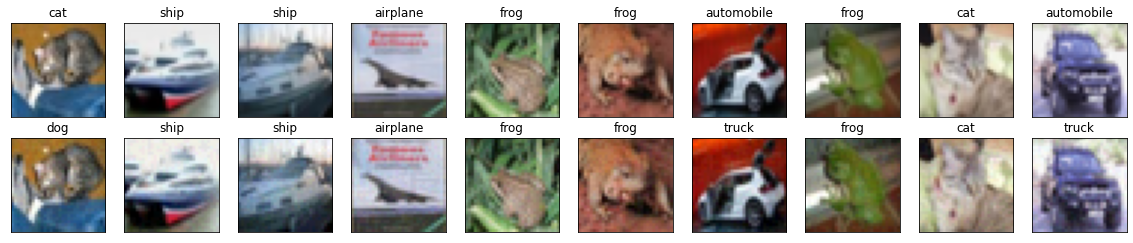

In [59]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  axis = plt.subplot(3, n, i + 1)
  plt.imshow(original_image_data[0][i])
  plt.title(cifar_10_class_labels[image_data_labels[0][i].numpy()])
  plt.gray()
  axis.get_xaxis().set_visible(False)
  axis.get_yaxis().set_visible(False)
  plt.grid(False)
  axis = plt.subplot(3, n, i + 1 + n)
  plt.imshow(tf.clip_by_value(adversarial_image_data[0][i], clip_value_min=0., clip_value_max=1.))
  plt.title(cifar_10_class_labels[adversarial_predictions[0][i].numpy()])
  plt.gray()
  axis.get_xaxis().set_visible(False)
  axis.get_yaxis().set_visible(False)

plt.show()

#### Train the model with epsilon = 0.1

In [15]:
start_adversarial_training(train_data, model, 0.1)

Loss: 16.452621459960938 Accuracy: 0.019999999552965164
Loss: 2.3029544353485107 Accuracy: 0.08856000006198883
Loss: 2.2980217933654785 Accuracy: 0.11568000167608261
Loss: 2.2971014976501465 Accuracy: 0.12817999720573425
Loss: 2.2351338863372803 Accuracy: 0.13259999454021454
Loss: 2.260835886001587 Accuracy: 0.1385599970817566
Loss: 2.2582573890686035 Accuracy: 0.1386999934911728
Loss: 2.2898974418640137 Accuracy: 0.14285999536514282
Loss: 2.2780771255493164 Accuracy: 0.14098000526428223
Loss: 2.2362444400787354 Accuracy: 0.1458600014448166


####Test the model with epsilon = 0.1

In [16]:
adversarial_predictions_2 = start_adversarial_testing(adversarial_image_dataset, model)

Test acc: 0.21089999377727509


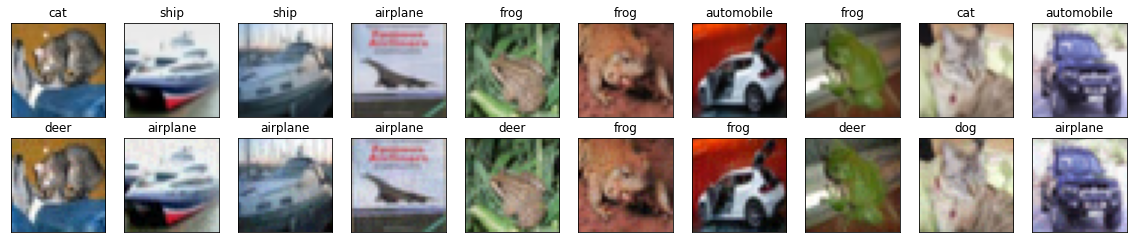

In [20]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  axis = plt.subplot(3, n, i + 1)
  plt.imshow(original_image_data[0][i])
  plt.title(cifar_10_class_labels[image_data_labels[0][i].numpy()])
  plt.gray()
  axis.get_xaxis().set_visible(False)
  axis.get_yaxis().set_visible(False)
  plt.grid(False)
  axis = plt.subplot(3, n, i + 1 + n)
  plt.imshow(tf.clip_by_value(adversarial_image_data[0][i], clip_value_min=0., clip_value_max=1.))
  plt.title(cifar_10_class_labels[adversarial_predictions_2[0][i].numpy()])
  plt.gray()
  axis.get_xaxis().set_visible(False)
  axis.get_yaxis().set_visible(False)

plt.show()